In [6]:
import os
import random
from collections import Counter, defaultdict
defaultdict
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import gaussian_filter1d
import torch.optim as optim
from torchvision import models
from torchvision import transforms

def load_image_sequences(root_dir):
    sequences = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if not os.path.isdir(label_path):
                continue
            for action in os.listdir(label_path):
                action_path = os.path.join(label_path, action)
                if not os.path.isdir(action_path):
                    continue
                image_paths = sorted(glob(os.path.join(action_path, '*.jpg')))
                for img_path in image_paths:
                    sequences.append({
                        'subject': subject,
                        'label': label,
                        'action': action,
                        'image_path': img_path
                    })
    return sequences

root_dir = '/kaggle/input/data-slayer123/train/train'
sequences = load_image_sequences(root_dir)

fall_sequences = [s for s in sequences if s['label'] == 'fall']
non_fall_sequences = [s for s in sequences if s['label'] == 'non_fall']

train_fall, test_fall = train_test_split(fall_sequences, test_size=0.2, random_state=42)
train_non_fall, test_non_fall = train_test_split(non_fall_sequences, test_size=0.2, random_state=42)

train_sequences = train_fall + train_non_fall
test_sequences = test_fall + test_non_fall

# Verifikasi distribusi label
train_labels = [s['label'] for s in train_sequences]
test_labels = [s['label'] for s in test_sequences]

print("Train label distribution:", Counter(train_labels))
print("Test label distribution:", Counter(test_labels))

Train label distribution: Counter({'non_fall': 2198, 'fall': 1186})
Test label distribution: Counter({'non_fall': 550, 'fall': 297})


In [7]:
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_transformations(sequences, transform):
    transformed_sequences = []
    for seq in sequences:
        img = cv2.imread(seq['image_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = np.expand_dims(img, axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = np.array(img, dtype=np.uint8)
        augmented_img = transform(img)
        transformed_sequences.append({
            'subject': seq['subject'],
            'label': seq['label'],
            'action': seq['action'],
            'image_tensor': augmented_img
        })
    return transformed_sequences

train_augmented = apply_transformations(train_sequences, augmentation)
test_transformed = apply_transformations(test_sequences, test_transform)

In [8]:
class SingleFrameDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        image = sequence['image_tensor']
        label = 1 if sequence['label'] == 'fall' else 0
        return image, label

batch_size = 4

train_dataset = SingleFrameDataset(train_augmented)
test_dataset = SingleFrameDataset(test_transformed)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class SingleFrameModel(nn.Module):
    def __init__(self, pretrained=True):
        super(SingleFrameModel, self).__init__()
        self.backbone = models.resnet18(pretrained=pretrained)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        x = self.backbone(x)
        return x

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SingleFrameModel(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


In [10]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    scheduler.step()

Epoch [1/3], Loss: 0.2732, Accuracy: 89.33%
Epoch [2/3], Loss: 0.1224, Accuracy: 96.25%
Epoch [3/3], Loss: 0.0652, Accuracy: 98.37%


In [ ]:

# Menyimpan model dan optimizer setelah selesai pelatihan
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
}, '1frame.pth')

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import torch
import cv2
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset class for testing single frames
class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Dataset for testing single frames by loading all images from a directory.

        Args:
            image_dir (str): Path to the directory containing test images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = glob(os.path.join(image_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = -1  # Placeholder since labels are not provided

        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {img_path}")

        # Convert grayscale to RGB
        img = np.expand_dims(img, axis=2)  # [H, W, 1]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # [H, W, 3]
        img = np.array(img, dtype=np.uint8)

        if self.transform:
            img = self.transform(img)  # [C, H, W]

        return img, label, img_path  # Return img_path for reference

# Define test directory and transformations
test_directory = '/kaggle/input/data-slayer123/test/test'
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create testing dataset and loader
testing_dataset = TestingDataset(image_dir=test_directory, transform=test_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

Predictions saved to 1frame.csv


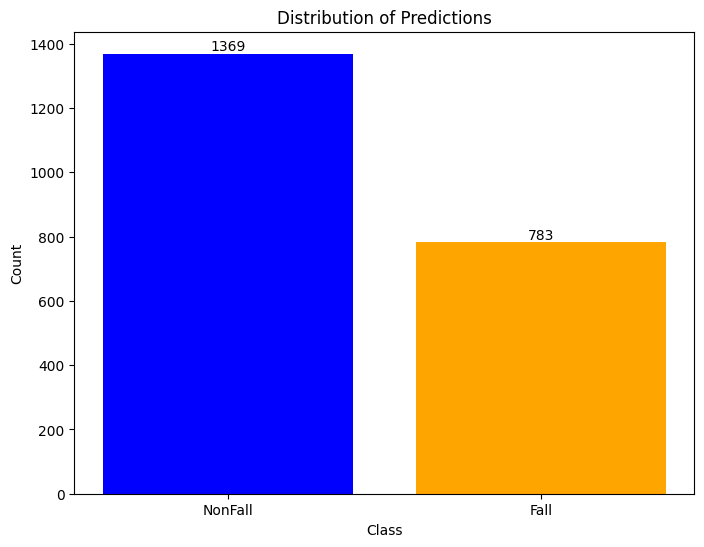

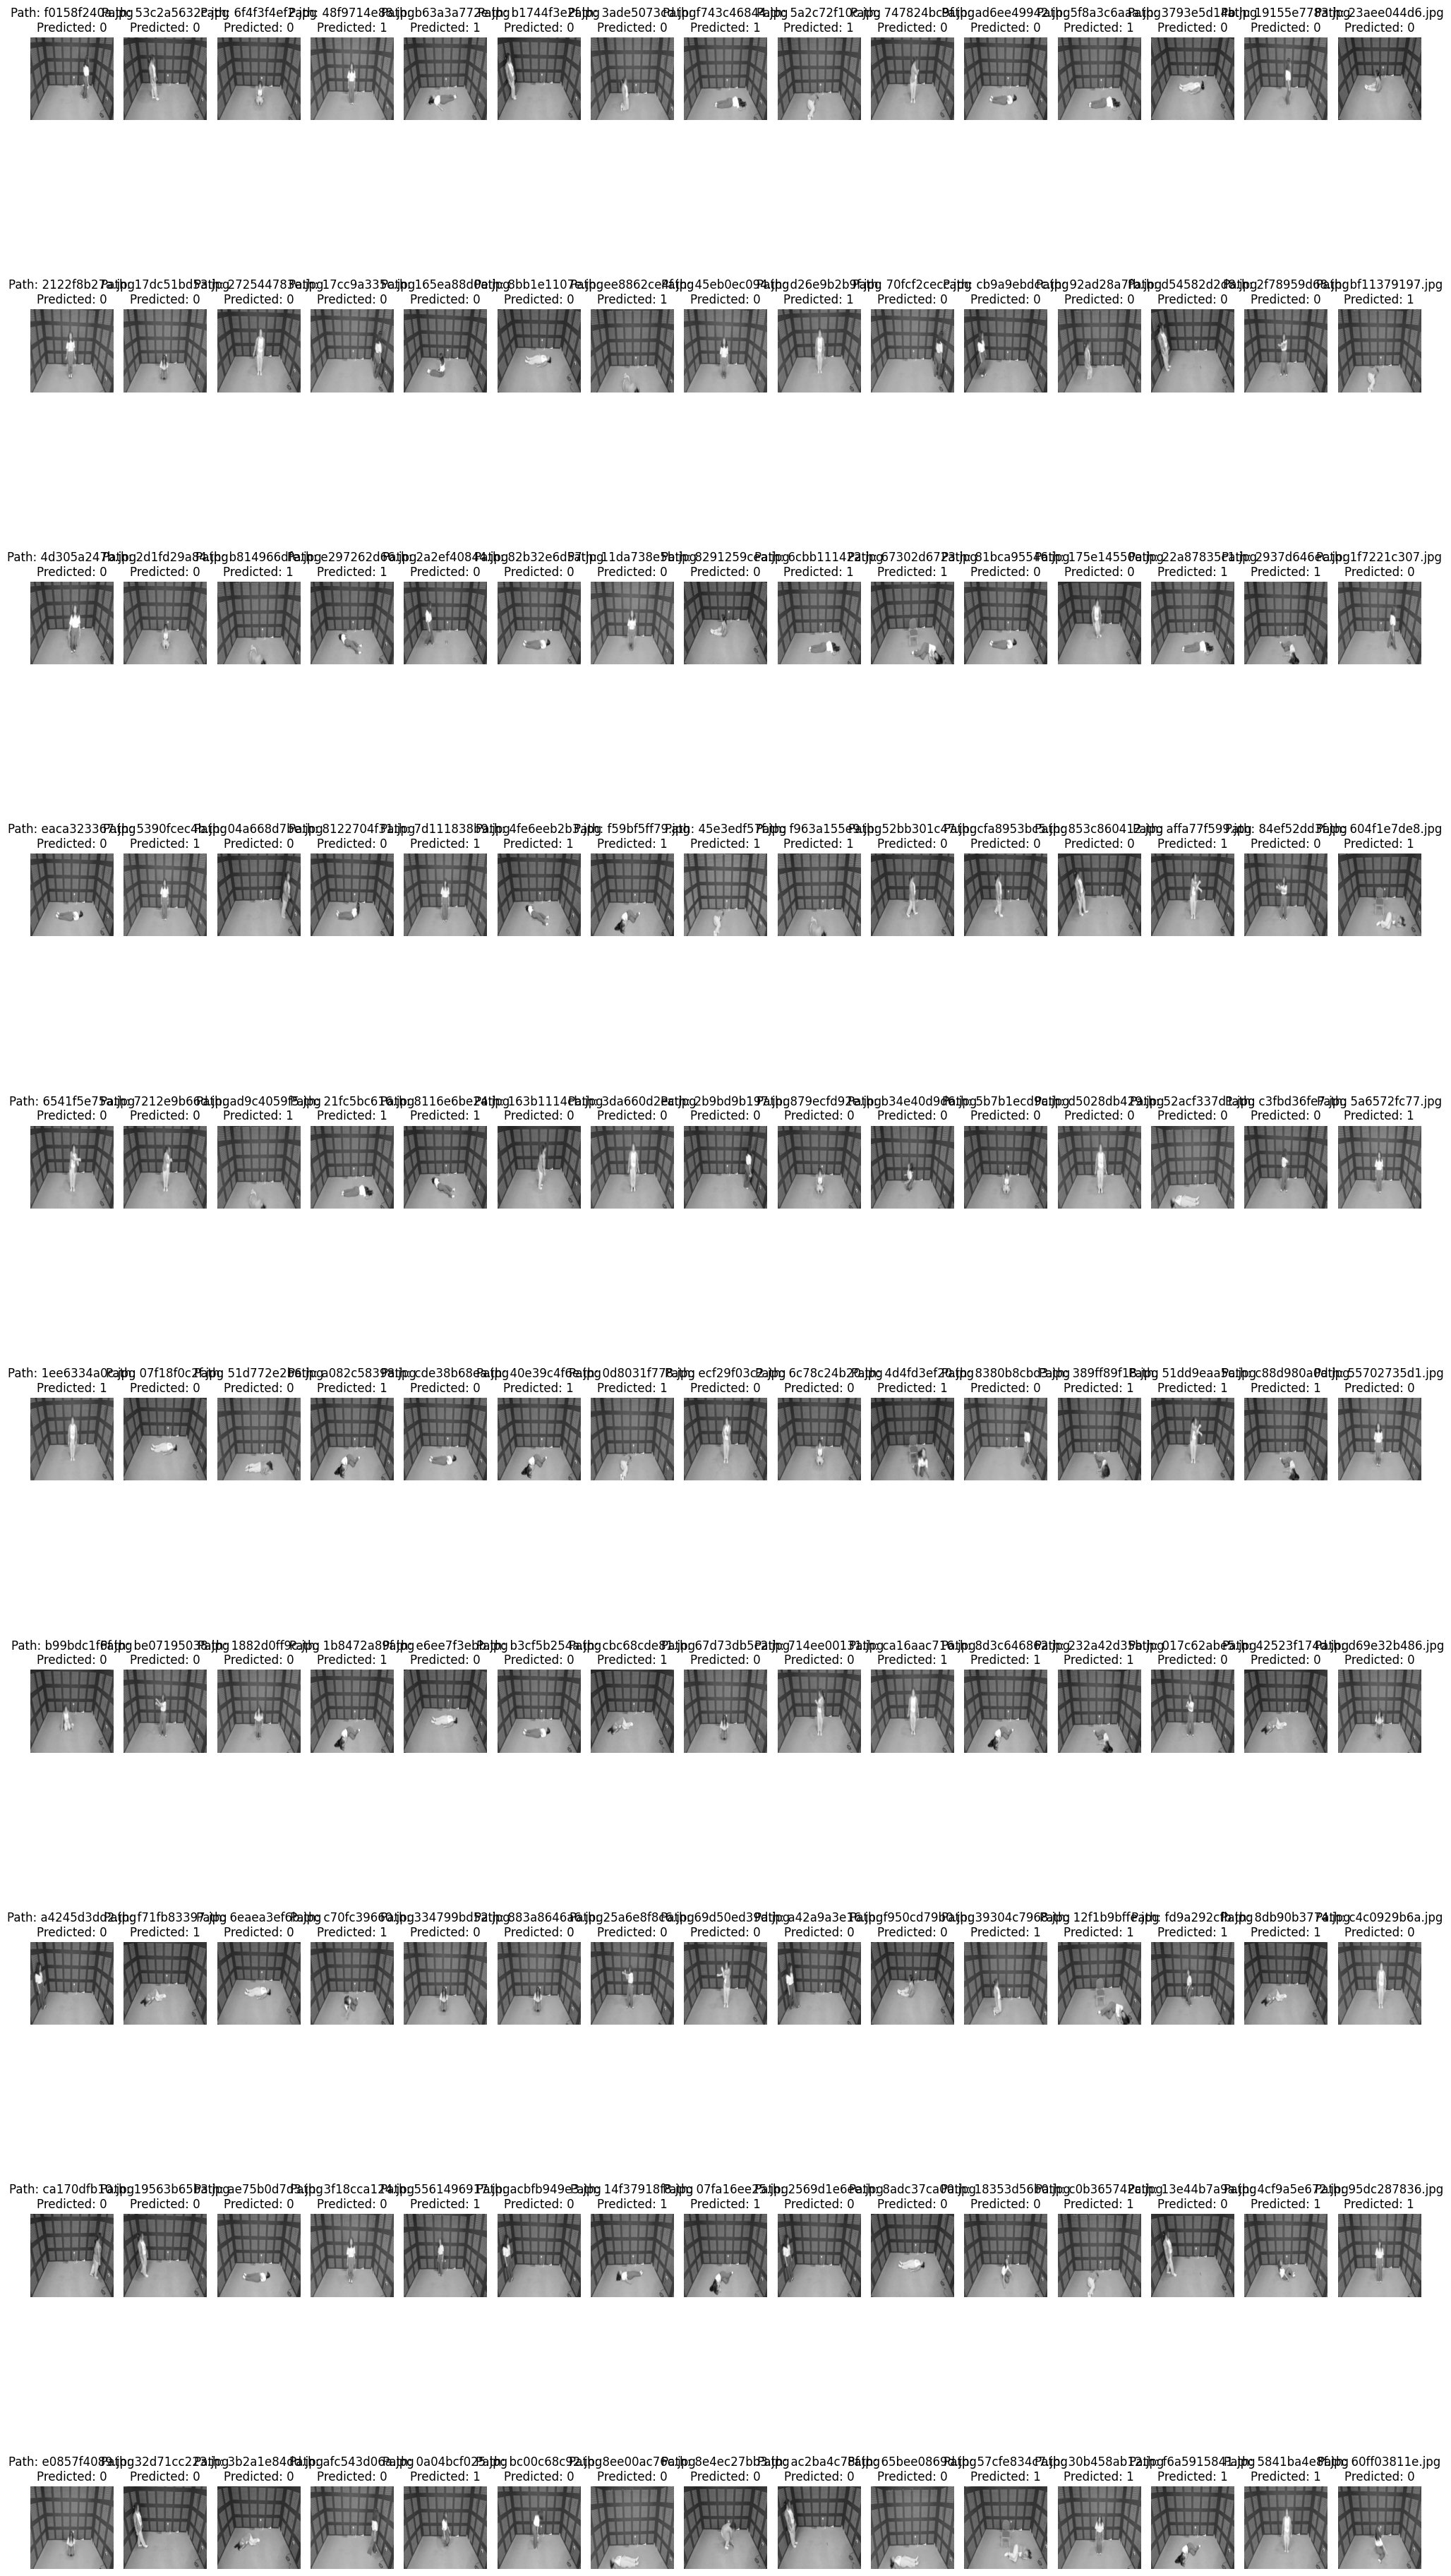

In [12]:
def evaluate_testing(model, testing_loader, device, num_samples=150, csv_path='predictions.csv'):
    """
    Evaluates the model on the testing dataset, visualizes random samples, and saves predictions to CSV.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        testing_loader (DataLoader): DataLoader for the testing dataset.
        device (torch.device): Device to perform computations on.
        num_samples (int): Number of random samples to visualize.
        csv_path (str): Path to save the CSV file with predictions.
    """
    model.eval()

    all_preds = []
    all_paths = []

    sample_images = []
    sample_preds = []
    sample_paths = []

    total_samples = len(testing_loader.dataset)

    num_samples = min(num_samples, total_samples)

    random_indices = set(random.sample(range(total_samples), num_samples))

    with torch.no_grad():
        for batch_idx, (images, labels, img_paths) in enumerate(testing_loader):
            # Move data to the specified device
            images = images.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            pred_label = predicted.item()

            img_path = img_paths[0]
            img_filename = os.path.basename(img_path)

            all_preds.append(pred_label)
            all_paths.append(img_filename)

            if batch_idx in random_indices and len(sample_images) < num_samples:
                img = images[0].cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # [H, W, C]
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                img = np.clip(img, 0, 1)
                sample_images.append(img)
                sample_preds.append(pred_label)
                sample_paths.append(img_filename)

    df = pd.DataFrame({
        'id': all_paths,
        'label': all_preds
    })

    df.to_csv(csv_path, index=False)

    print(f'Predictions saved to {csv_path}')

    distribution = df['label'].value_counts().sort_index()
    labels = ['NonFall', 'Fall']
    counts = distribution.tolist()
    plt.figure(figsize=(8,6))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

    num_plots = len(sample_images)
    cols = 15  # Update columns to 15 to fit more images per row
    rows = (num_plots + cols - 1) // cols  # Calculate rows needed to fit images

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i in range(num_plots):
        axes[i].imshow(sample_images[i])
        axes[i].set_title(f'Path: {sample_paths[i]}\nPredicted: {sample_preds[i]}')
        axes[i].axis('off')

    for i in range(num_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Evaluate the model on the testing dataset
evaluate_testing(model, testing_loader, device, num_samples=150, csv_path='1frame.csv')


In [13]:
predictions_path = "/kaggle/working/1frame.csv"
sample_submission_path = "/kaggle/input/sample/sample_submission.csv"
merged_output_path = "Bismillah_1frame.csv"

predictions = pd.read_csv(predictions_path)

sample_submission = pd.read_csv(sample_submission_path)
merged = pd.merge(sample_submission, predictions, on='id', how='inner')

merged = merged[['id', 'label_y']].rename(columns={'label_y': 'label'})
merged.to_csv(merged_output_path, index=False)

print(f'Merged CSV saved to {merged_output_path}')

Merged CSV saved to Bismillah_1frame.csv
